# __Méthode de gradient stochastique pour l'apprentissage d'un réseau de neurones sur un problème jouet de classification .__

<h1><a id='toc'></a>Sommaire</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ul>
        <li><a href="#0">0. Données du problème d'optimisation </a></li>
        <li><a href="#I">1. Implémentation de la méthode du gradient stochastique à taux d'apprentissage constant (rappel) </a></li>
        <li><a href="#II">2. Réduction du bruit par décroissance du taux d'apprentissage</a></li> 
        <li><a href="#III">3. Méthodes des mini-lots (mini-batch method)</a></li> 
    </ul>

Importation des bibliothèques

In [1]:
from toynn_2023 import *
# charge aussi les bibliothèques suivantes :
#    import numpy as np
#    from numpy import random as nprd
#    from matplotlib import pyplot as plt
#    from matplotlib import cm as cm
#    from copy import deepcopy as dcp

<h2><a id='0'></a>
0.  Données du problème d'optimisation </h2> 

<a href="#toc">top</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#0">0</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#I">1.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#II">2.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#III">3.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#bot">bot.</a>

### Sélection d'un problème ###

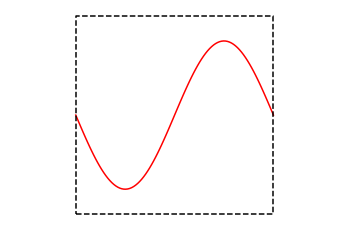

In [2]:
pb = ToyPb(name = "sin", bounds = (-1,1))
pb.show_border()

### Création d'un ensemble de données taguées à l'aide du problème précédent. 

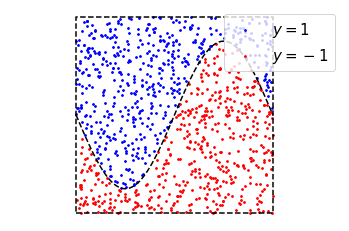

In [3]:
ndata = 1000
data = nD_data(n = ndata, pb = pb)

data.show_class()
pb.show_border('k--')
plt.legend(loc=1, fontsize=15)
plt.show()

### Apprentissage. 

_pb_ et _data_ étant donnés, on souhaite fabriquer une fonction $h$ parmi un ensemble de fonctions de la forme $h(\cdot;A)$ où le paramètre $A$ évolue librement dans $\mathbb{R}^N$ qui minimise
$$
F(A):=\dfrac1{n_d}\sum_{i=0}^{n_d-1}\ell(h(x^i;A)y^i)=\,\dfrac1{n_d}\sum_{i=0}^{n_d-1}f_i(A).
$$
où $n_d=$*data.n*, $x^i=$*data.X*[i], $y^i=$*data.Y*[i] et $\ell=$*pb.loss*. 

Plus bas on fixe un type de réseau de neurones dont les paramètres $A$ sont les poids associés aux arrêtes et aux noeuds.  Ces réseaux de neurones ont deux noeud d'entrées auxquels on assignera les valeurs $x^i_0,x^i_1$ et un noeud en sortie qui produira la valeur $h((x^i_0,x^i_1;A)$.

### Création d'un type de réseau de neurones

Le type de réseau de neurones est caractérisé par le nombre de couches et le nombre de noeuds dans chaque couche ainsi que par une fonction d'activation $\chi$.<br>
Ici on choisit 5 couches avec respectivement 2, 4, 6, 4 et 1 noeuds et on prend  $\chi(t)=tanh(t)$.

Le paramètre _grid=(-1,1,41)_ sert pour les représentation graphiques de la sortie produite par un réseau de neurones pour les entrées $(x_i,y_j)$ parcourant les noeuds de la grille régulière obtenue par discrétisation du carré $[-1,1]\times[-1,1]$ avec le pas $h=1/20$.
$$
x_i=-1+ih,\qquad y_j=-1+jh\qquad\text{ avec }0\le i,j\le 40.
$$

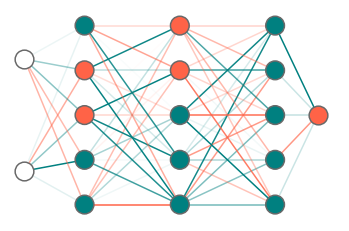

In [4]:
CardNodes = (2, 5, 5, 5, 1)
nn = ToyNN(card = CardNodes, chi="tanh", grid=(-1,1,41))

# Exemple de coefficients et représentation
A= nn.create_rand()
nn.show(A)

<h2><a id='I'></a>
1.  Implémentation de la méthode du gradient stochastique à taux d'apprentissage constant </h2> 

<a href="#toc">top</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#0">0</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#I">1.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#II">2.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#III">3.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#bot">bot.</a>

Un pas de la méthode de gradient stochastique consiste à choisir aléatoirement (et uniformément) $i_k\in\{0,\dots,n_d-1\}$ puis à faire :
$$
A^{k+1}\ \longleftarrow\ A^k - \alpha\nabla f_{i_k}(A^k),
$$
où le taux d'apprentissage $\alpha>0$ est fixé.

L'indice $i_k$ tiré aléatoirement à l'étape $k$ l'est indépendemment des indices précédents $i_0,i_1,\dots,i_{k-1}$.

__Initialisation__. On définit:<br>
&nbsp;&nbsp;&nbsp;&nbsp;
($*$) Un ensemble de coefficients initial sous la forme d'une coef-list _A_ construite au hasard.<br>
&nbsp;&nbsp;&nbsp;&nbsp;
($*$) Un flottant _alpha_ correspondant au taux d'apprentissage ($\alpha=0.05$ ici).<br>
&nbsp;&nbsp;&nbsp;&nbsp;
($*$) Un nombre d'époques total _Nepoch_.<br>
&nbsp;&nbsp;&nbsp;&nbsp;
($*$) Un entier _nepoch_ initialisé  à 0 qui va représenter le nombre d'époques effectuées.<br>
&nbsp;&nbsp;&nbsp;&nbsp;
($*$) Un entier _Ndata_ représentant la taille des données.<br>
&nbsp;&nbsp;&nbsp;&nbsp;
($*$) Un entier _nepochplot_ qui indique la fréquence des représentations graphiques au cours des itérations (une représentation graphique toutes les _niterplot_ époques). <br>
&nbsp;&nbsp;&nbsp;&nbsp;
($*$) Une liste vide *Total_loss* pour stocker l'évolution de l'erreur totale au cours des itérations.

In [5]:
# Paramètres
alpha=0.005
Nepoch=300
Ndata=data.n
nepochplot=25

nplot_per_row = 4 # nombre de figure par ligne

# Initialisations
A=nn.create_rand()
nepoch=0
Erreur =[nn.total_loss(A,data,pb=pb)]
plotpos=0

__Boucle d'optimisation__. Noter que les deux boucles sur *i\_* et sur *j\_* pourraient être rassemblées en une seule boucle. Cette décomposition ne sert qu'à compter des époques. 

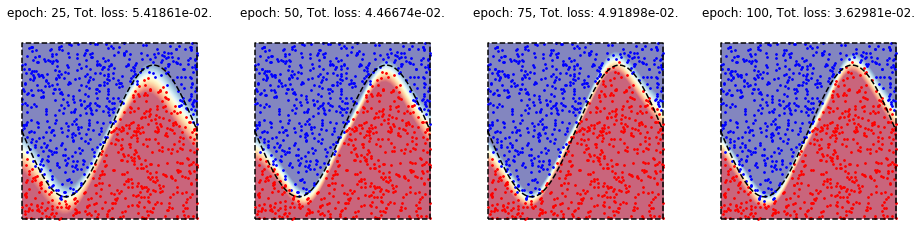

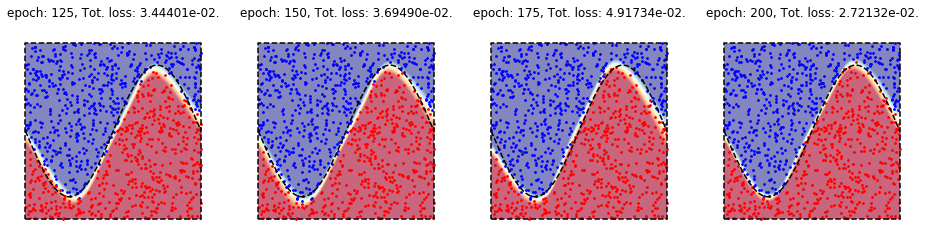

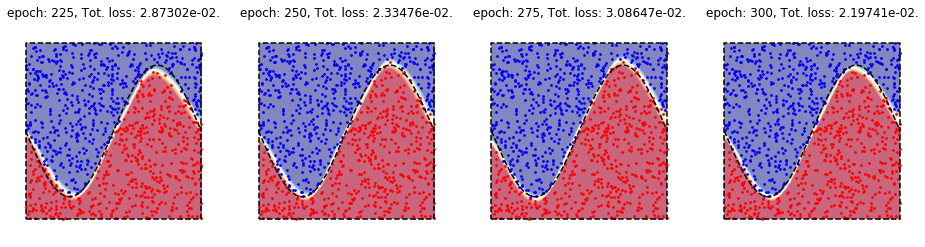

In [6]:
# Boucle d'optimisation pour la methode du gradient stochastique
for i_ in range(Nepoch):
    nepoch+=1
    for j_ in range(Ndata):
        i = nprd.randint(Ndata)
        x, y = data.X[i], data.Y[i]
        dA = nn.descent(A, x, y, alpha=alpha, pb=pb)
        nn.add(A, dA, output=False)
    
    # calcul de l'erreur et représentations graphiques
    if not nepoch%nepochplot:
        error = nn.total_loss_and_prediction(A,data,pb=pb)
        Erreur.append(error)
        if not plotpos: plt.figure(figsize=(16,4))
        plotpos+=1
        plt.subplot(1,nplot_per_row,plotpos)
        data.show_class(pred=True)
        nn.show_pred(A)
        pb.show_border('k--')
        plt.title(f"epoch: {nepoch}, Tot. loss: {error:1.5e}.", fontsize=12)
        if plotpos==nplot_per_row :  
            plt.show()
            plotpos=0
    else:
        error = nn.total_loss(A,data,pb=pb)
        Erreur.append(error)

__Étude graphique de l'évolution de l'erreur totale__

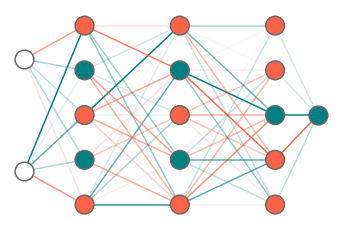

Erreur initiale : 9.03756e-01


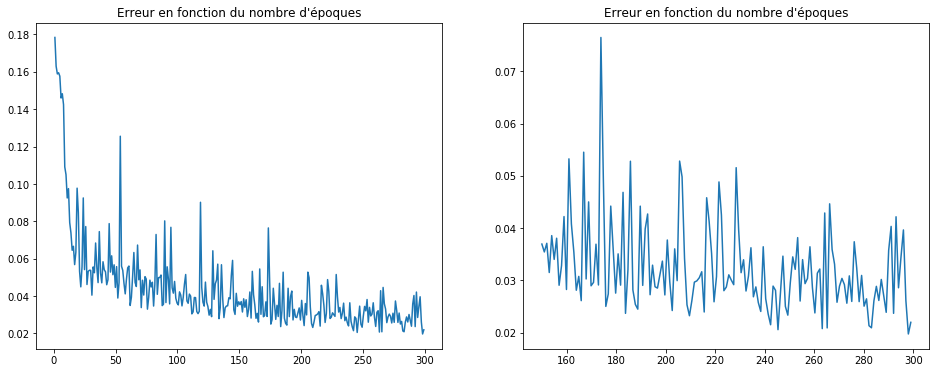

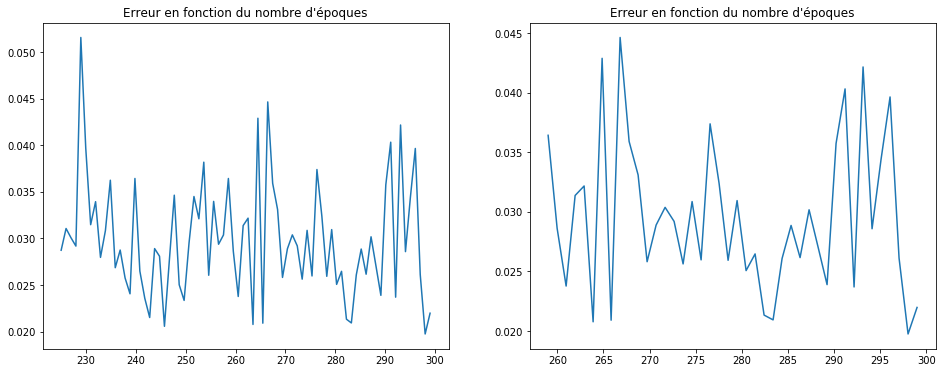

In [7]:
## Représentations graphiques de l'évolution de l'erreur au cours des époques.
nn.show(A)

print(f"Erreur initiale : {Erreur[0]:1.5e}")

plt.figure(figsize=(16,6))
plt.subplot(121)
debut = 1
plt.plot(np.linspace(debut, nepoch-1,nepoch-debut + 1),Erreur[debut:])
plt.title("Erreur en fonction du nombre d'époques")

plt.subplot(122)
debut = nepoch//2
plt.plot(np.linspace(debut, nepoch-1,nepoch-debut + 1),Erreur[debut:])
plt.title("Erreur en fonction du nombre d'époques")
plt.show()

plt.figure(figsize=(16,6))
plt.subplot(121)
debut = 3*(nepoch//4)
plt.plot(np.linspace(debut, nepoch-1,nepoch - debut + 1),Erreur[debut:])
plt.title("Erreur en fonction du nombre d'époques")

plt.subplot(122)
debut = 7*(nepoch//8)
plt.plot(np.linspace(debut, nepoch-1,nepoch - debut + 1),Erreur[debut:])
plt.title("Erreur en fonction du nombre d'époques")
plt.show()

**Exercice 1.**

(a) Commentez l'évolution de l'erreur. Donnez des explications.

(b) Changez la valeur du taux d'apprentissage. Observez et commentez. 

<div class="alert alert-block alert-info" style="margin-top : 0px">
    
__Solution 1.__

    
</div>

(a) On voit que l'erreur diminue globalement avant d'atteindre une zone d'instabilité à partir de 220 epoch.



(b) Changeons la valeur du taux d'apprentissage en diminuant alpha.

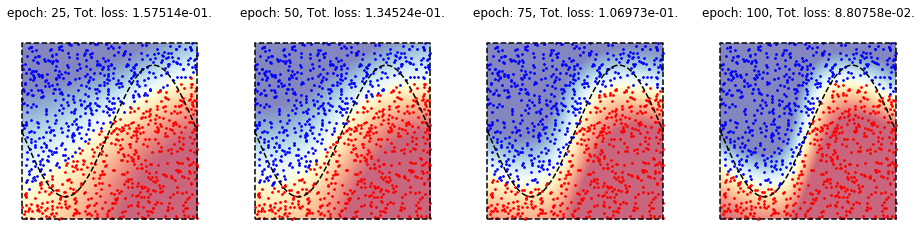

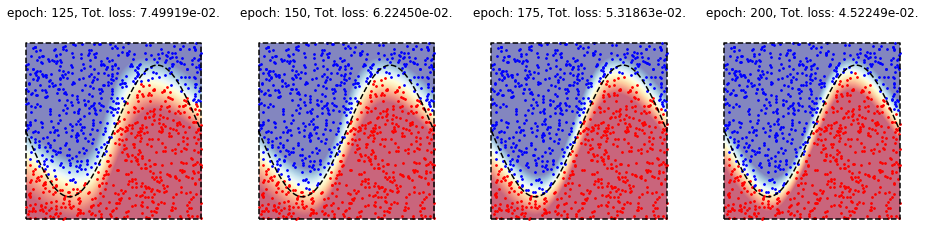

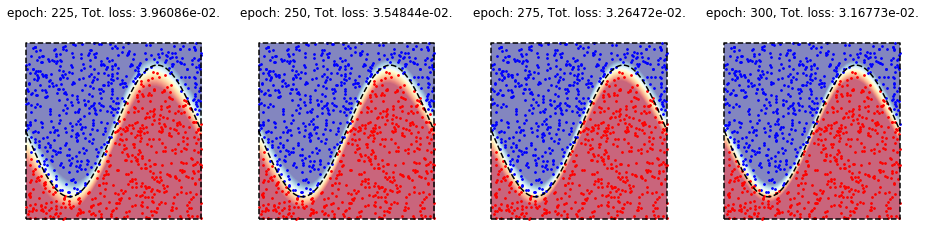

In [8]:
# Paramètres
alpha=0.0005
Nepoch=300
Ndata=data.n
nepochplot=25

nplot_per_row = 4 # nombre de figure par ligne

# Initialisations
A=nn.create_rand()
nepoch=0
Erreur =[nn.total_loss(A,data,pb=pb)]
plotpos=0

# Boucle d'optimisation pour la methode du gradient stochastique
for i_ in range(Nepoch):
    nepoch+=1
    for j_ in range(Ndata):
        i = nprd.randint(Ndata)
        x, y = data.X[i], data.Y[i]
        dA = nn.descent(A, x, y, alpha=alpha, pb=pb)
        nn.add(A, dA, output=False)
    
    # calcul de l'erreur et représentations graphiques
    if not nepoch%nepochplot:
        error = nn.total_loss_and_prediction(A,data,pb=pb)
        Erreur.append(error)
        if not plotpos: plt.figure(figsize=(16,4))
        plotpos+=1
        plt.subplot(1,nplot_per_row,plotpos)
        data.show_class(pred=True)
        nn.show_pred(A)
        pb.show_border('k--')
        plt.title(f"epoch: {nepoch}, Tot. loss: {error:1.5e}.", fontsize=12)
        if plotpos==nplot_per_row :  
            plt.show()
            plotpos=0
    else:
        error = nn.total_loss(A,data,pb=pb)
        Erreur.append(error)


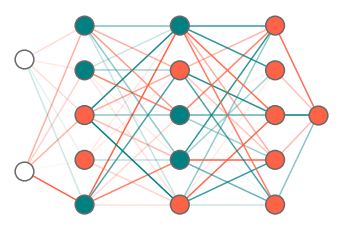

Erreur initiale : 1.49984e+00


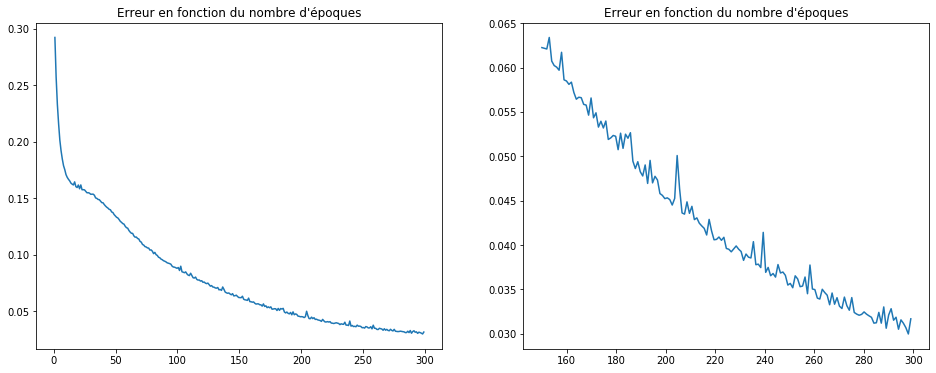

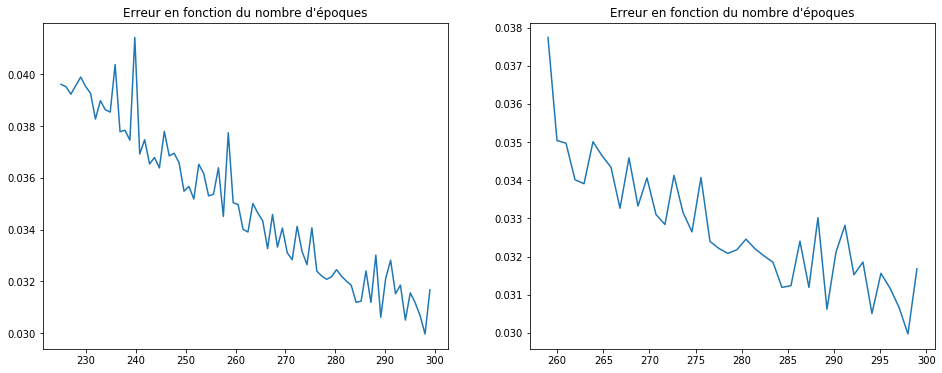

In [9]:
## Représentations graphiques de l'évolution de l'erreur au cours des époques.
nn.show(A)

print(f"Erreur initiale : {Erreur[0]:1.5e}")

plt.figure(figsize=(16,6))
plt.subplot(121)
debut = 1
plt.plot(np.linspace(debut, nepoch-1,nepoch-debut + 1),Erreur[debut:])
plt.title("Erreur en fonction du nombre d'époques")

plt.subplot(122)
debut = nepoch//2
plt.plot(np.linspace(debut, nepoch-1,nepoch-debut + 1),Erreur[debut:])
plt.title("Erreur en fonction du nombre d'époques")
plt.show()

plt.figure(figsize=(16,6))
plt.subplot(121)
debut = 3*(nepoch//4)
plt.plot(np.linspace(debut, nepoch-1,nepoch - debut + 1),Erreur[debut:])
plt.title("Erreur en fonction du nombre d'époques")

plt.subplot(122)
debut = 7*(nepoch//8)
plt.plot(np.linspace(debut, nepoch-1,nepoch - debut + 1),Erreur[debut:])
plt.title("Erreur en fonction du nombre d'époques")
plt.show()

<h2><a id='II'></a>
2. Réduction du bruit par décroissance du taux d'apprentissage</h2> 

<a href="#toc">top</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#0">0</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#I">1.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#II">2.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#III">3.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#bot">bot.</a>

Pour réduire progressivement le bruit, on fait décroître le taux d'apprentissage au cours des _itérations_. L'itération $k$ devient :<br>
&nbsp;&nbsp;&nbsp;&nbsp;
Calculer le taux d'apprentissage $\alpha_k$.<br>
&nbsp;&nbsp;&nbsp;&nbsp; 
Choisir aléatoirement (et uniformément) $i\in\{0,\dots,n_d-1\}$.<br>
&nbsp;&nbsp;&nbsp;&nbsp; 
Faire :
$$
A\ \longleftarrow\ A - \alpha_k\nabla f_i(A),
$$

Nous proposons pour $\alpha_k$ la formule
$$\tag{1}
\alpha_k := \dfrac{\lambda\alpha_0}{\lambda+k}=\dfrac{\alpha_0}{1+ k/\lambda},
$$
où les paramètres $\alpha_0$ et $\lambda$ sont strictement positifs

**Exercice 2.** Donnez des arguments pour le choix des paramètres $\alpha_0$ et $\lambda$ (du moins donnez une méthode pour déterminer l'ordre de grandeur de paramètres conduisant à un algorithme efficace). 

On pourra vérifier le bien fondé de ces choix en testant la méthode (Exercice 3).

<div class="alert alert-block alert-info" style="margin-top : 0px">

**Solution 2.**
    
</div>

**Exercice 3.** Implémentez la méthode du gradient stochastique avec le taux d'apprentissage variable donné par la formule (1).

In [ ]:
## Solution 3.a
# Paramètres et initialisations

In [ ]:
## Solution 3.b
# Boucle d'optimisation pour la methode du GS avec décroissance de alpha

In [ ]:
## Solution 3.c
## Représentations graphiques de l'évolution de l'erreur au cours des époques.

**Exercice 4.** Commentez les résultats numériques. Observe-t-on les effets décrits en cours ?

<div class="alert alert-block alert-info" style="margin-top : 0px">

__Solution 4.__ 
    
</div>

<h2><a id='III'></a>3. Méthodes des mini-lots (mini-batch method)</h2> 

<a href="#toc">top</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#0">0</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#I">1.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#II">2.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#III">3.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#bot">bot.</a>

La méthode des mini-lots est une méthode intermédiare entre la méthode du gradient (full batch) et la méthode du gradient stochastique. Au lieu de considérer une seule fonction $f_{i_k}$ à l'étape $k$, on tire un lot de $n_k$ fonctions $f_{i_{k,0}},\dots,f_{i_{k,n_k-1}}$ et on fait 
$$
A^{k+1}\ \longleftarrow\ A^k-\alpha_k\dfrac1{n_k}\sum_{j=0}^{n_k-1}\nabla f_{i_{k,j}}(A_k).
$$
Notez que le calcul des $\nabla f_{i_{k,j}}(A_k)$ peut être effectué en parallèle.

**Exercice 5.** 

(i) Implémentez et testez la méthode de mini-batch sur le problème défini plus haut. On prendra $n_k=n_{\text{batch}}=30$ (indépendant de $k$) et dans un premier temps un taux d'apprentissage constant. 

On rappelle que le nombre d'itérations par époque est $\lfloor n_d/n_{\text{batch}}\rfloor$. 

(ii) Comparez la méthode de mini-batch et la méthode de gradient stochastique pur. Est-ce que les taux d'apprentissage permettant la convergence sont les mêmes que dans le cas du gradient stochastique pur ? Pour un même taux d'apprentissage, y-a-il une différence dans l'évolution de l'erreur au cour des itérations?

(iii) Implémentez la méthode du mini-batch avec $\alpha_k$ donné par la formule (1).

(iv) Quels sonts les conclusions générales que vous tirez du TP ? 

In [ ]:
## Solution 5.i.a
# Paramètres et initialisations

In [ ]:
## Solution 5.i.b
# Boucle d'optimisation pour la methode du GS avec décroissance de alpha

In [ ]:
## Solution 5.i.c
## Représentations graphiques de l'évolution de l'erreur au cours des époques.

<div class="alert alert-block alert-info" style="margin-top : 0px">
    
**Solution 5.ii.** 

</div>

<div class="alert alert-block alert-info" style="margin-top : 0px">
    
**Solution 5.iii.** 
    
</div>

<div class="alert alert-block alert-info" style="margin-top : 0px">
    
**Solution 5.iv.** 

</div>

<a href="#toc">top</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#0">0</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#I">1.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#II">2.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#III">3.</a>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<a href="#bot">bot.</a>
<a id='bot'></a>